In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cd "/content/drive/MyDrive/wine_label"

### *`import library`*

In [3]:
import os 
import glob
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape, Dropout, Activation, BatchNormalization, Add
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D

### *`read dataset`*

In [4]:
name_list = glob.glob('/content/drive/MyDrive/wine_label/*')

In [5]:
len(name_list)

164

In [6]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [7]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    for layer in conv_base.layers:
        layer.trainable = False

    # freeze weights of convolution layers

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_model((224, 224, 3), 24)

58889256/58889256 [==============================] - 1s 0us/step


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
X = []
y = []

for name in name_list:
    label = (((name.split('/')[-1]).split('.'))[0])[0:-2]
    y.append(label)
    img = cv2.imread(name)
    img = cv2.resize(img, (224, 224))
    X.append((img))
y = np.array(y)
X = np.array(X)
print(y.shape)
print(X.shape)

(164,)
(164, 224, 224, 3)


In [10]:
num_classes = np.unique(y)
print(num_classes.shape)

(24,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(114, 224, 224, 3) (114,) (50, 224, 224, 3) (50,)


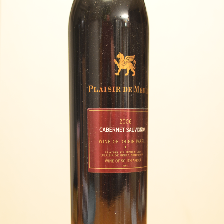

'cabernet_sauvignon'

In [12]:
from google.colab.patches import cv2_imshow

img = cv2_imshow(X_test[9])
y_test[9]

In [13]:
X_train_new = np.array(X_train) / 255.
X_test_new = np.array(X_test) / 255.

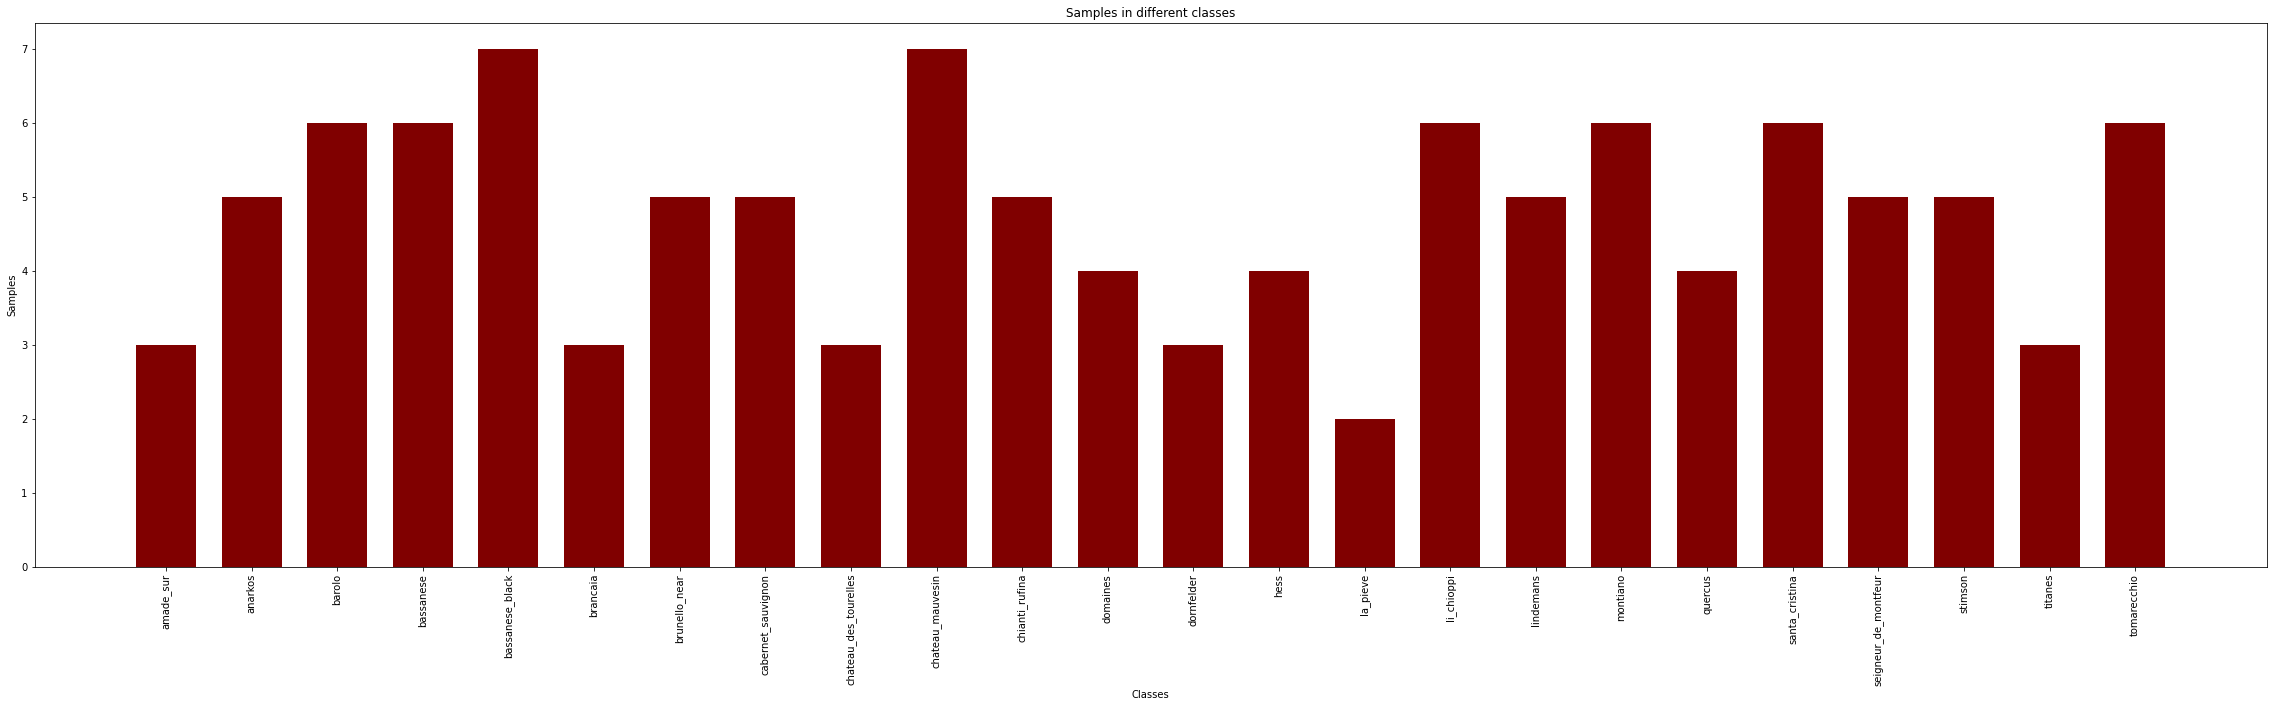

In [14]:
unique, counts = np.unique(y_train, return_counts = True)
plt.figure(figsize = (40,10))
plt.bar(unique, counts, color = 'maroon', width = 0.7)
unique_ = np.arange(len(unique))
plt.xticks(unique_, unique, rotation = 90)
plt.xlabel('Classes')
plt.ylabel('Samples')

plt.title('Samples in different classes')
plt.show()

### *`one hot encoder`*

In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1,1))
y_train_new = encoder.transform(y_train.reshape(-1,1)).toarray()
y_test_new = encoder.transform(y_test.reshape(-1,1)).toarray()
labels = encoder.get_feature_names_out()

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_new))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_new))

In [17]:
y_train_new

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

### *`data augmentation`*

In [59]:
from tensorflow.keras import layers

def data_agu(images, labels, aug):

    images = aug(images)
    
    return images, labels

augment_layers = tf.keras.Sequential([
    layers.RandomBrightness([-0.6,0.6]),  # type: ignore
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.1),
    layers.RandomRotation(0.3),
    layers.RandomZoom(
		  height_factor=(-0.05, -0.15),
		  width_factor=(-0.05, -0.15)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.Rescaling(scale=1.0 / 255.),
])

In [60]:
BATCH_SIZE = 16
train_ds = (train_ds.map(lambda img, label: data_agu(img, label, augment_layers), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .batch(BATCH_SIZE))

test_ds = (test_ds.batch(BATCH_SIZE)
                  .map(lambda x, y: (tf.cast(x, tf.float32), y))
                  .map(lambda x, y: (x / 255., y)))


In [61]:
dataset_length = [i for i,_ in enumerate(train_ds)][-1] + 1
dataset_length

8

In [62]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.3, 0.5),
    horizontal_flip=True,
    vertical_flip=True,
    dtype=np.float32
)
aug.fit(X_train)

In [63]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1,1))
y_train_new = encoder.transform(y_train.reshape(-1,1)).toarray()
y_test_new = encoder.transform(y_test.reshape(-1,1)).toarray()
labels = encoder.get_feature_names_out()

In [ ]:
labels

array(['x0_amade_sur', 'x0_anarkos', 'x0_barolo', 'x0_bassanese',
       'x0_bassanese_black', 'x0_brancaia', 'x0_brunello_near',
       'x0_cabernet_sauvignon', 'x0_chateau_des_tourelles',
       'x0_chateau_mauvesin', 'x0_chianti_rufina', 'x0_domaines',
       'x0_dornfelder', 'x0_hess', 'x0_la_pieve', 'x0_li_chioppi',
       'x0_lindemans', 'x0_montiano', 'x0_quercus', 'x0_santa_cristina',
       'x0_seigneur_de_montfeur', 'x0_stimson', 'x0_titanes',
       'x0_tomarecchio'], dtype=object)

### *`Visualize`*

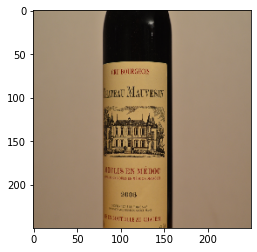

In [18]:
name = name_list[0]
img = cv2.imread(name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (250, 250))
plt.imshow(img)

### *`training `*

In [19]:
model = create_model((224, 224, 3), 24)
# model.summary()

In [20]:
y_train.shape

(114,)

In [21]:
history = model.fit(X_train, y_train_new, epochs = 30, batch_size=32, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 55s 19s/step - loss: 164.4398 - accuracy: 0.0549 - val_loss: 110.1238 - val_accuracy: 0.2609
Epoch 2/30
3/3 [==============================] - 52s 19s/step - loss: 125.6873 - accuracy: 0.2527 - val_loss: 30.2434 - val_accuracy: 0.4348
Epoch 3/30
3/3 [==============================] - 52s 19s/step - loss: 7.0346 - accuracy: 0.8352 - val_loss: 0.6454 - val_accuracy: 0.8696
Epoch 4/30
3/3 [==============================] - 53s 19s/step - loss: 0.6495 - accuracy: 0.9560 - val_loss: 0.4497 - val_accuracy: 0.9565
Epoch 5/30
3/3 [==============================] - 51s 18s/step - loss: 0.0839 - accuracy: 0.9890 - val_loss: 0.2308 - val_accuracy: 0.9565
Epoch 6/30
3/3 [==============================] - 51s 18s/step - loss: 0.7712 - accuracy: 0.9780 - val_loss: 2.1754e-04 - val_accuracy: 1.0000
Epoch 7/30
3/3 [==============================] - 51s 18s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 8/30
3/3 [

In [22]:
model.evaluate(X_test, y_test_new)

2/2 [==============================] - 26s 12s/step - loss: 0.0565 - accuracy: 0.9800


[0.05649775639176369, 0.9800000190734863]

### *`ResNet model`*

In [ ]:
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample = False):
        # channels: same as number of convolution kernels
        super().__init__()
        self.__channels = channels 
        self.__down_sample = down_sample
        self.__strides = [2,1] if down_sample else [1,1]

        KERNEL_SIZE = (3,3)
        INIT_SCHEME = 'he_normal'

        self.conv_1 = Conv2D(self.__channels, strides = self.__strides[0], kernel_size = KERNEL_SIZE, padding = 'same', kernel_initializer = INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides = self.__strides[1], kernel_size = KERNEL_SIZE, padding = 'same', kernel_initializer = INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            self.res_conv = Conv2D(self.__channels, strides = 2, kernel_size = (1,1), kernel_initializer = INIT_SCHEME, padding = 'same')
            self.res_bn = BatchNormalization()
        
    def call(self, inputs):
        res = inputs
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)
        x = self.merge([x,res])
        out = tf.nn.relu(x)
        return out

In [ ]:
class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7,7), strides = 2, padding = 'same', kernel_initializer = 'he_normal')
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample = True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out        

In [ ]:
model = ResNet18(24)
model.build(input_shape = (None, 250, 250, 3))
from keras.optimizers import SGD
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "res_net18_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_120 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_48 (ResnetBloc  multiple                 74368     
 k)                                                              
                                                                 
 resnet_block_49 (ResnetBloc  multiple                 74368     
 k)                                                    

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights = True, monitor = 'val_accuracy', mode = 'max')
STEPS = len(X_train) / 256.
history = model.fit(train_ds, validation_data = test_ds, epochs = 20, batch_size = 16, callbacks = es )

Epoch 1/20
9/9 [==============================] - 56s 6s/step - loss: 3.0739 - accuracy: 0.2137 - val_loss: 23969.1074 - val_accuracy: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 51s 6s/step - loss: 1.4873 - accuracy: 0.5649 - val_loss: 17242.4180 - val_accuracy: 0.0303
Epoch 3/20
9/9 [==============================] - 51s 6s/step - loss: 0.8912 - accuracy: 0.6947 - val_loss: 5593.8379 - val_accuracy: 0.0303
Epoch 4/20
9/9 [==============================] - 52s 6s/step - loss: 0.3058 - accuracy: 0.9008 - val_loss: 1108.9822 - val_accuracy: 0.0000e+00
Epoch 5/20
9/9 [==============================] - 51s 6s/step - loss: 0.1258 - accuracy: 0.9847 - val_loss: 370.5239 - val_accuracy: 0.0000e+00
Epoch 6/20
9/9 [==============================] - 51s 6s/step - loss: 0.0489 - accuracy: 1.0000 - val_loss: 106.6813 - val_accuracy: 0.0000e+00
Epoch 7/20
9/9 [==============================] - 51s 6s/step - loss: 0.0310 - accuracy: 0.9924 - val_loss: 42.5511 - val_accuracy: 0.0000

In [ ]:
from keras.callbacks import EarlyStopping 

es = EarlyStopping(patience=3, restore_best_weights = True, monitor = 'val_accuracy', mode = 'max')
STEPS = len(X_train) / 256.
history = model.fit(aug.flow(X_train, y_train_new, batch_size=16), validation_data=(X_train, y_train_new), epochs = 50, batch_size = 16, callbacks = [es])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 4.9561 - accuracy: 0.0408

TypeError: ignored

### *`Plot results `*

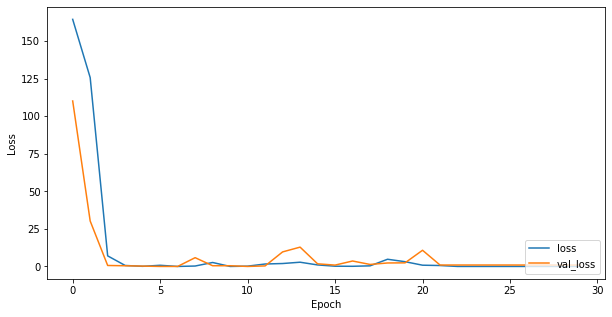

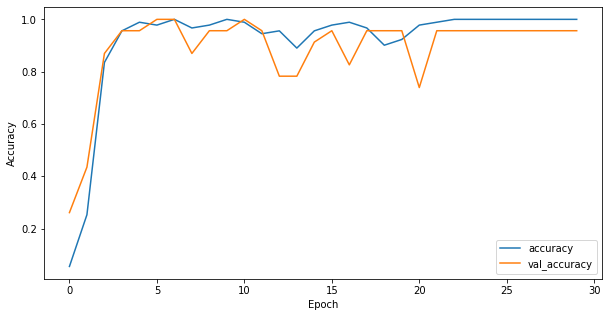

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()  